In [1]:
import torch
import torch.nn as nn
from utils import get_data, min_max_normalize, prepare_data, create_dataloaders, set_seed
from model import MembraneModel, Trainer, ModelEvaluator
import json

# set seed for reproducibility
set_seed(42)

# Pfade
data_csv = '../../../data/interpolation/auswertung_gesamt_8N_10N_12N_15N_17N_18N_20N.csv'

In [ ]:
data = get_data(data_csv)
norm_data, _, _ = min_max_normalize(data)

## Splitting the Data

In [3]:
batch_size = 64

# Data with x and y only
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(norm_data, targets='xy')
train_loader_xy, val_loader_xy, test_loader_xy = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)
# Data with F only
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(norm_data, targets='f')
train_loader_f, val_loader_f, test_loader_f = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)

## Training Model with different Loss Functions

- MSE Loss: $L = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$
- L1 Loss / MAE Loss: $L = \frac{1}{N} \sum_{i=1}^{N} |y_i - \hat{y}_i|$
- Smooth L1 Loss / Huber Loss: 
  $
  L = \begin{cases} 
      \frac{1}{2}(y_i - \hat{y}_i)^2 & \text{for } |y_i - \hat{y}_i| \leq \delta \\ 
      \delta (|y_i - \hat{y}_i| - \frac{1}{2}\delta) & \text{for } |y_i - \hat{y}_i| > \delta 
      \end{cases}
  $

In [10]:
loss_fns = {
    "mse": nn.MSELoss(),
    "l1": nn.L1Loss(),
    "smooth_l1": nn.SmoothL1Loss(beta=1.0),
}
epochs = 500
lr = 0.0013

results = {}

for name, loss_fn in loss_fns.items():
    # Models
    model_xy = MembraneModel(output_dim=2)
    model_f = MembraneModel(output_dim=1)

    # Optimizers
    optimizer_xy = torch.optim.Adam(model_xy.parameters(), lr=lr)
    optimizer_f = torch.optim.Adam(model_f.parameters(), lr=lr)

    # Trainers
    trainer_xy = Trainer(model_xy, loss_fn, optimizer_xy, device='cuda')
    trainer_f = Trainer(model_f, loss_fn, optimizer_f, device='cuda')

    # Training
    trainer_xy.fit(train_loader_xy, val_loader_xy, epochs=epochs)
    trainer_f.fit(train_loader_f, val_loader_f, epochs=epochs)

    # Test Losses
    test_loss_xy = trainer_xy.test(test_loader_xy)
    test_loss_f = trainer_f.test(test_loader_f)

    # Store results
    results[name] = {
        "test_loss_xy": test_loss_xy,
        "test_loss_f": test_loss_f,
        "model_xy_path": f"../../../models/loss_fn_variation/model_xy_{name}.pt",
        "model_f_path": f"../../../models/loss_fn_variation/model_f_{name}.pt",
    }

    # save models
    torch.save(model_xy.state_dict(), f"../../../models/loss_fn_variation/model_xy_{name}.pt")
    torch.save(model_f.state_dict(),  f"../../../models/loss_fn_variation/model_f_{name}.pt")

    print(f'{name} - Test Loss XY: {test_loss_xy:.4f}')
    print(f'{name} - Test Loss F: {test_loss_f:.4f}')

# Save results to a JSON file
with open("../../../models/loss_fn_variation/results.json", "w") as f:
    json.dump(results, f, indent=4)

Starting training...
Starting training...
mse - Test Loss XY: 56.7708
mse - Test Loss F: 0.2394
Starting training...
Starting training...
l1 - Test Loss XY: 5.6041
l1 - Test Loss F: 1.1473
Starting training...
Starting training...
smooth_l1 - Test Loss XY: 6.9956
smooth_l1 - Test Loss F: 0.1714


In [ ]:
evaluator_xy = ModelEvaluator(model_class=MembraneModel, test_loader=test_loader_xy, output_dim=2, device='cuda')
xy_results = evaluator_xy.evaluate_from_json("../../../models/loss_fn_variation/results.json")
#best_xy_mse = evaluator_xy.find_best_loss(metric='mse')
#best_xy_mae = evaluator_xy.find_best_loss(metric='mae')
#best_xy_rmse = evaluator_xy.find_best_loss(metric='rmse')

evaluator_f = ModelEvaluator(model_class=MembraneModel, test_loader=test_loader_f, output_dim=1, device='cuda')
f_results = evaluator_f.evaluate_from_json("../../../models/loss_fn_variation/results.json")
#best_f_mse = evaluator_f.find_best_loss(metric='mse')
#best_f_mae = evaluator_f.find_best_loss(metric='mae')
#best_f_rmse = evaluator_f.find_best_loss(metric='rmse')


Evaluating loss: mse
{'mse': 56.770774841308594, 'mae': 5.355298042297363, 'rmse': 7.534638404846191}

Evaluating loss: l1
{'mse': 54.8547477722168, 'mae': 5.604146957397461, 'rmse': 7.406399250030518}

Evaluating loss: smooth_l1
{'mse': 83.01515197753906, 'mae': 7.478462219238281, 'rmse': 9.111265182495117}

Best loss function: Model_l1 with metric_mse: 54.8547

Best loss function: Model_mse with metric_mae: 5.3553

Evaluating loss: mse
{'mse': 0.23935693502426147, 'mae': 0.3609963059425354, 'rmse': 0.48924118280410767}

Evaluating loss: l1
{'mse': 1.5816066265106201, 'mae': 1.1472725868225098, 'rmse': 1.2576193809509277}

Evaluating loss: smooth_l1
{'mse': 0.36152881383895874, 'mae': 0.4892496168613434, 'rmse': 0.6012726426124573}

Best loss function: Model_mse with metric_mse: 0.2394

Best loss function: Model_mse with metric_mae: 0.3610


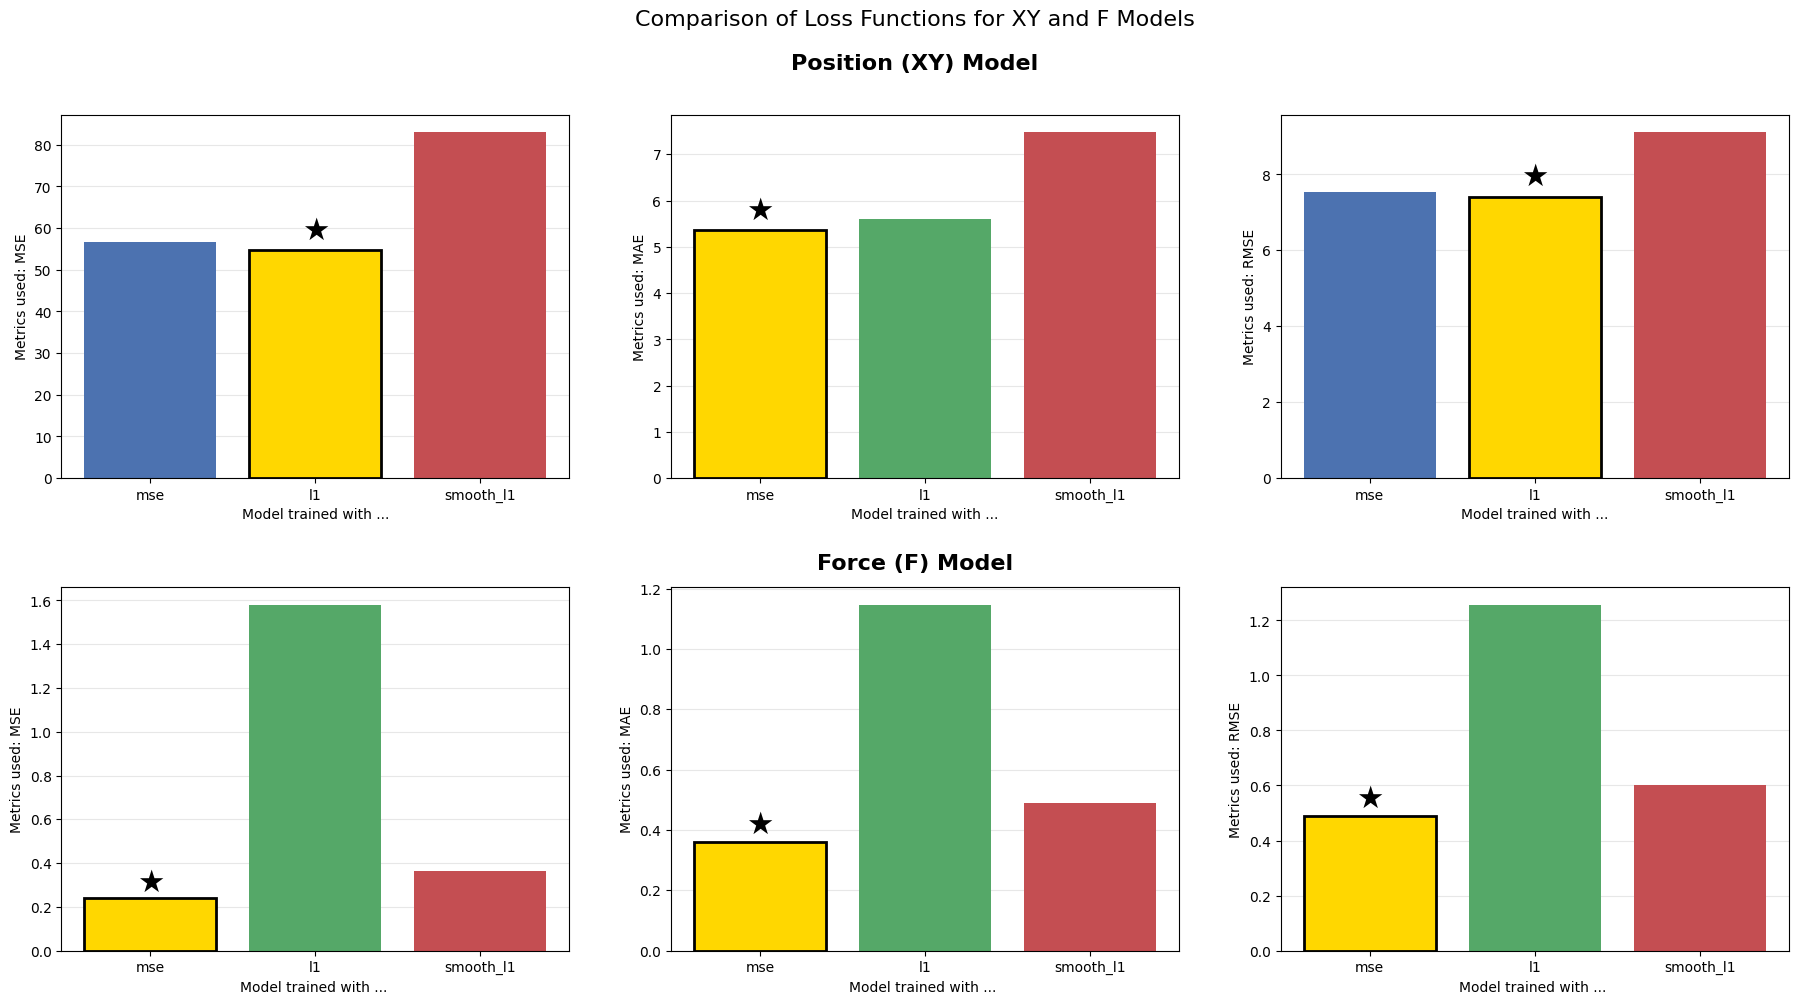

In [45]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["mse", "mae", "rmse"]
loss_functions = list(xy_results.keys())

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Comparison of Loss Functions for XY and F Models", fontsize=16)
fig.text(0.5, 0.92, "Position (XY) Model", ha='center', fontsize=16, fontweight='bold')
fig.text(0.5, 0.42, "Force (F) Model", ha='center', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.93])
fig.subplots_adjust(hspace=0.30, wspace=0.2)

# --- XY MODEL (row 0) ---
for i, metric in enumerate(metrics):

    # Werte extrahieren
    values = np.array([xy_results[loss][metric] for loss in loss_functions])

    # Besten Wert finden
    best_index = np.argmin(values)

    ax = axes[0, i]
    bars = ax.bar(loss_functions, values, color=['#4c72b0', '#55a868', '#c44e52'])

    # Beste Bar markieren
    bars[best_index].set_color("#FFD700")  # Gold
    bars[best_index].set_edgecolor("black")
    bars[best_index].set_linewidth(2)

    # Stern einzeichnen
    ax.text(best_index,
            values[best_index] * 1.02,
            "★",
            ha='center', va='bottom', fontsize=22, color='black')

    ax.set_xlabel("Model trained with ...")
    ax.set_ylabel(f"Metrics used: {metric.upper()}")
    ax.grid(axis='y', alpha=0.3)
    ax.set_axisbelow(True)

# --- F MODEL (row 1) ---
for i, metric in enumerate(metrics):

    values = np.array([f_results[loss][metric] for loss in loss_functions])
    best_index = np.argmin(values)

    ax = axes[1, i]
    bars = ax.bar(loss_functions, values, color=['#4c72b0', '#55a868', '#c44e52'])

    bars[best_index].set_color("#FFD700")  # Gold
    bars[best_index].set_edgecolor("black")
    bars[best_index].set_linewidth(2)

    ax.text(best_index,
            values[best_index] * 1.02,
            "★",
            ha='center', va='bottom', fontsize=22, color='black')

    ax.set_xlabel("Model trained with ... ")
    ax.set_ylabel(f"Metrics used: {metric.upper()}")
    ax.grid(axis='y', alpha=0.3)
    ax.set_axisbelow(True)

plt.savefig("../../../figs/loss_function_comparison.png", dpi=160, bbox_inches='tight')

# 📄 Conclusion: Evaluation of Loss Functions for Position (XY) and Force (F) Prediction

In dieser Untersuchung wurden drei verschiedene Loss Functions — MSE, L1 und SmoothL1 — 
für zwei Regressionsaufgaben verglichen:

1. Vorhersage der Position des Lastpunkts (X, Y)
2. Vorhersage der wirkenden Kraft (F)

Jedes Modell wurde mit einer der Loss Functions trainiert und anschließend anhand der 
Metriken MSE, MAE und RMSE bewertet. Die Plots markieren jeweils die beste Loss Function 
mit einem Sternsymbol.

---------------------------------------------------------------------

# 🟦 1. Position Prediction (XY-Model)

Für die XY-Vorhersage ist klar:

⭐ Bestes Modell für XY: **L1 Loss**

- L1 liefert die niedrigsten Werte für MSE, MAE und RMSE.
- SmoothL1 schneidet in allen XY-Metriken am schlechtesten ab.
- L1 reagiert robuster auf Messrauschen und nichtlineare Deflektionsformen.

👉 Fazit für XY:
**L1 Loss eignet sich am besten zur Vorhersage der Position.**

---------------------------------------------------------------------

# 🟩 2. Force Prediction (F-Model)

Für die Kraftvorhersage gilt:

⭐ Bestes Modell für F: **MSE Loss**

- MSE liefert die niedrigsten Fehler für MSE, MAE und RMSE.
- L1 ist zu unsensitiv für die kontinuierliche Kraftänderung.
- SmoothL1 liegt im Mittelfeld.

👉 Fazit für F:
**MSE Loss ist die beste Wahl für die Kraftvorhersage.**

---------------------------------------------------------------------

# 🟧 3. Gesamtüberblick

| Task            | Beste Loss Function | Grund |
|-----------------|---------------------|-------|
| Position (XY)   | L1                  | Robust gegen Rauschen, geringste Fehler |
| Force (F)       | MSE                 | Beste Sensitivität, stabilste Vorhersagen |

---------------------------------------------------------------------

# ✅ Final Recommendation

- Trainiere das **XY-Modell mit L1 Loss**
- Trainiere das **F-Modell mit MSE Loss**

Diese Kombination liefert die insgesamt besten Ergebnisse und sorgt für stabile,
physikalisch konsistente Vorhersagen.
